# Analyzing NYC High School Data

We will work with the fillowing interrelated data sets about New York City public schools:

- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City

- [SAT scores by school](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City

- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school

- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school

- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information

- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school

- [School survey](https://data.cityofnewyork.us/Education/2010-2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

### Reading in the data

In [1]:
# reading in the CSV files

import pandas as pd
data_files = ["ap_2010.csv",
"class_size.csv",
"demographics.csv",
"graduation.csv",
"hs_directory.csv",
"sat_results.csv"]

data = {}
for file in data_files:
    data[file.replace(".csv","")] = pd.read_csv(file)

In [2]:
# Reading in the survey data

all_survey = pd.read_csv("survey_all.txt",delimiter="\t",encoding="windows-1252")
d75_survey = pd.read_csv("survey_d75.txt",delimiter="\t",encoding="windows-1252")
survey = pd.concat([all_survey,d75_survey],axis=0,sort=True)

### Cleaning the Data

In [3]:
# Cleaning Up the Surveys

survey["DBN"]=survey["dbn"]
survey = survey.loc[:,["DBN","rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]]
data["survey"] = survey

In [4]:
# Inserting DBN Fields

data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad(n):
    if len(str(n)) > 1:
        return str(n)
    else:
        return str(n).zfill(2)

data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

In [5]:
# Combining the SAT Scores

cols = ["SAT Math Avg. Score","SAT Critical Reading Avg. Score","SAT Writing Avg. Score"]
for col in cols:
    data["sat_results"][col] = pd.to_numeric(data["sat_results"][col],errors="coerce")

data["sat_results"]["sat_score"] = data["sat_results"][cols[0]] + data["sat_results"][cols[1]] + data["sat_results"][cols[2]]

In [6]:
# Parsing Geographic Coordinates for Schools

import re

def get_lat(location):
    return re.findall("\(.+\)",location)[0].split(",")[0].replace('(',"")

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(get_lat)

def get_lon(location):
    return re.findall("\(.+\)",location)[0].split(",")[1].replace(')',"")

data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(get_lon)

#### Condensing the Class Size Data Set

In [7]:
class_size = data['class_size']

In [8]:
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

#### Computing Average Class Sizes

In [9]:
import numpy as np

In [10]:
class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size
data["class_size"].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


#### Condensing the Demographics Data Set

In [11]:
demographics = data["demographics"]

In [12]:
demographics = demographics[demographics['schoolyear'] == 20112012]
demographics.head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


In [13]:
data["demographics"] = demographics

#### Condensing the Graduation Data Set

In [14]:
data["graduation"] = data["graduation"][data["graduation"]['Cohort'] == '2006']

In [15]:
data["graduation"] = data["graduation"][data["graduation"]['Demographic'] == 'Total Cohort']

#### Converting AP Test Scores

In [16]:
cols = ['AP Test Takers ', 'Total Exams Taken','Number of Exams with scores 3 4 or 5']
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

#### Performing the Left Joins

In [17]:
combined = data["sat_results"]

In [18]:
combined = combined.merge(data["ap_2010"], on='DBN',how= 'left')

In [19]:
combined = combined.merge(data["graduation"], on='DBN',how= 'left')

#### Performing the Inner Joins

In [20]:
to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for i in to_merge:
    combined = combined.merge(data[i], on='DBN',how= 'inner')

#### Filling in Missing Values

In [21]:
combined = combined.fillna(combined.mean())

In [22]:
combined = combined.fillna(0)

#### Adding a School District Column for Mapping

In [23]:
def get_first_two(str):
    return str[0:2]

In [24]:
combined["school_dist"] = combined["DBN"].apply(get_first_two)

In [25]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.71376394700047,-73.98526003999967,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.7123318510005,-73.98479662499966,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729782687000466,-73.98304144099967,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569079000484,-73.98567269099965,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725451000466,-73.97942638599966,01


### Exploring the Data

#### Finding correlations

In [26]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

#### Plotting survey correlations

In [27]:
import warnings
warnings.filterwarnings('ignore')
survey_fields = ["DBN","rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
combined.corr()["sat_score"][survey_fields].plot.bar()

#### Exploring Safety and SAT Scores

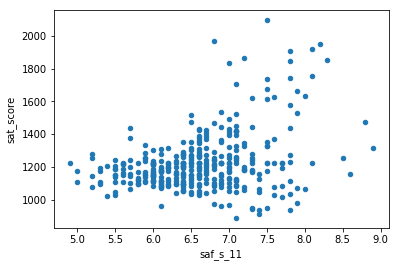

In [28]:
combined.plot.scatter("saf_s_11", "sat_score")

#### Plotting safety

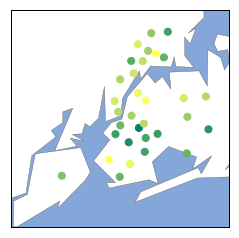

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

combined['lat'] = pd.to_numeric(combined['lat'])
combined['lon'] = pd.to_numeric(combined['lon'])

districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

m = Basemap(
projection='merc',
llcrnrlat=40.496044,
urcrnrlat=40.915256,
llcrnrlon=-74.255735,
urcrnrlon=-73.700272,
resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")

#### Exploring Race and SAT Scores

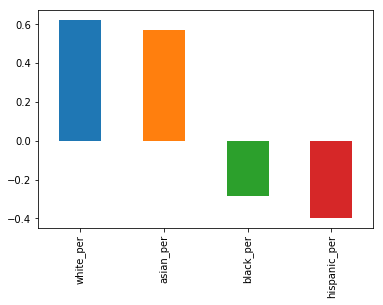

In [32]:
combined.corr()["sat_score"][["white_per", "asian_per", "black_per", "hispanic_per"]].plot.bar()

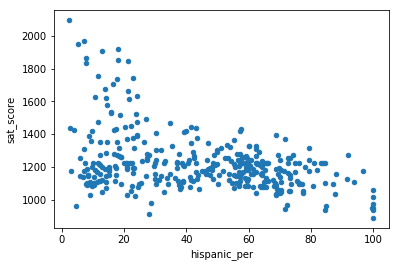

In [36]:
combined.plot.scatter("hispanic_per", "sat_score")

In [37]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [38]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


#### Exploring Gender and SAT Scores

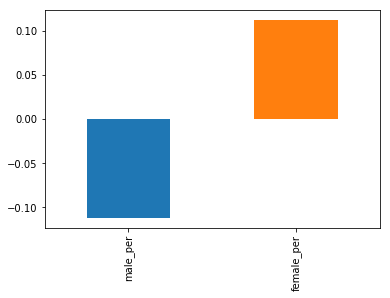

In [39]:
combined.corr()["sat_score"][["male_per", "female_per"]].plot.bar()

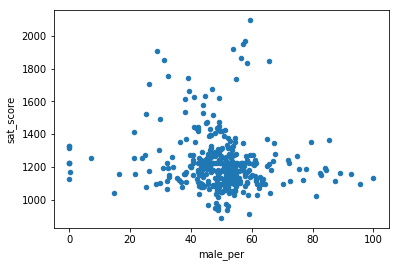

In [42]:
combined.plot.scatter("male_per", "sat_score")

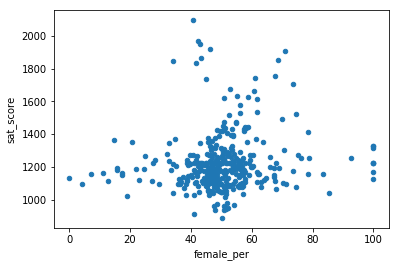

In [43]:
combined.plot.scatter("female_per", "sat_score")

In [44]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Exploring AP Scores vs. SAT Scores

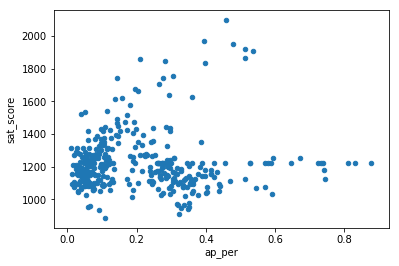

In [45]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')